In [1]:
import os
import cv2
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from typing import Literal
from torchvision import models
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_img_paths(dir_path):

    img_paths = []
    for img in os.listdir(dir_path):
        img_paths.append(os.path.join(dir_path,img))
    return img_paths

In [3]:
marigold = load_img_paths('dataset\marigold')
sunflower = load_img_paths('dataset\sunflower')

marigold = list(zip(marigold,[0]*len(marigold)))
sunflower = list(zip(sunflower,[1]*len(sunflower)))

dataset = marigold+sunflower

# train test split while maintaining class balance
_,labels = zip(*dataset)
train , test = train_test_split(dataset,test_size=0.2,stratify=labels)

In [4]:
class flowerDataset(Dataset):
    def __init__(self,data,img_size=(225,225),device=torch.device('cpu')):
        super().__init__()
        self.device = device
        self.data = data
        self.img_size = img_size

        # self.transform = transforms.Compose(
        #     [
        #         transforms.Resize(self.img_size),
        #         transforms.ToTensor()
        #     ]
        # )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        img_path,label = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_size)
        img = img/255.0
        
        # img_tensor = self.transform(img).permute(2,0,1).float()

        img_tensor = torch.from_numpy(img).permute(2,0,1).float()
        label_tensor = torch.tensor(label).float()
        
        img_tensor.to(self.device)
        label_tensor.to(self.device)

        return img_tensor,label_tensor

In [5]:
import cv2
x = cv2.imread(marigold[0][0])
x = cv2.cvtColor(x,cv2.COLOR_BGR2RGB)

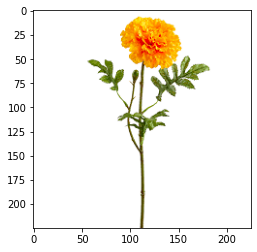

In [6]:
plt.imshow(x)

In [7]:
class VGG_Block(nn.Module):
    def __init__(self,in_channel=3,out_channels=32):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channel,out_channels=out_channels,kernel_size=3,stride=1,padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.relu = nn.ReLU()

    def forward(self,data):
        x = self.conv(data)
        x = self.relu(x)
        x = self.max_pool(x)

        return x

In [8]:
class VGG(nn.Module):
    def __init__(self,num_blocks:Literal[1,3],in_channels=3,img_shape=(225,225)):
        super().__init__()

        self.reshape = nn.AdaptiveAvgPool2d(img_shape)
        if num_blocks==1:
            self.num_blocks = num_blocks    
            self.block1 = VGG_Block()
            self.ll1 = nn.Linear(112*112*32,128) 
        
        elif num_blocks==3:
            self.num_blocks = 3                                                        
            self.block1 = VGG_Block()
            self.block2 = VGG_Block(in_channel=32,out_channels=64)
            self.block3 = VGG_Block(in_channel=64,out_channels=128)
            self.ll1 = nn.Linear(28*28*128,128) 

        self.ll2 = nn.Linear(128,1)


    def forward(self,x):
        x = self.reshape(x)

        if self.num_blocks==1:
            out = self.block1(x)

        elif self.num_blocks==3:
            x = self.block1(x)
            x = self.block2(x)
            out = self.block3(x)

        out = out.view(x.shape[0],-1)

        
        out = self.ll1(out)
        out = self.ll2(out)

        return out

In [9]:
from tqdm import tqdm

In [10]:
def evaluate_model(model, test_loader,loss_fn):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for img, label in test_loader:
            output = model(img)
            label = label.view(-1, 1)
            loss = loss_fn(output, label)
            total_loss += loss.item()
            
            predicted = (output > 0.5).float()
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

    average_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples
    return average_loss, accuracy


In [11]:
writer = SummaryWriter(log_dir='./logs')

In [12]:
# def train_model(model,log_dir,chkpt_path):    
    
#     optimizer = torch.optim.SGD(model.parameters(),lr = 0.1)
#     loss_fn = nn.BCEWithLogitsLoss()
#     min_loss = float('inf')
#     patience = 5
#     iteration = 0
    
#     writer = SummaryWriter(log_dir=log_dir)

#     for epoch in range(1000):
#         if patience == 0:
#             print(f"Early stopping at epoch {epoch}")
#             break

#         iter_loss=[]
#         model.train()
#         with tqdm(train_loader, desc=f'Epoch {epoch + 1}', unit='batch', leave=False) as pbar:
#             for batch_no, (img, label) in enumerate(pbar):
#                 optimizer.zero_grad()
#                 output = model(img)
#                 label = label.view(-1, 1)

#                 loss = loss_fn(output, label)
#                 loss.backward()
#                 optimizer.step()

#                 predicted = (output > 0.5).float()  
#                 accuracy = (predicted == label.view(-1, 1)).float().mean()

#                 writer.add_scalar('Training Loss', loss.item(), iteration)
#                 writer.add_scalar('Training Accuracy', accuracy.item(), iteration)

#                 pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item())

#                 iteration += 1 

#                 test_loss,test_accuracy = evaluate_model(model, test_loader,loss_fn)
                
#                 writer.add_scalar('Test Loss', test_loss, iteration)
#                 writer.add_scalar('Test Accuracy', test_accuracy, iteration)

#                 iter_loss.append(test_loss)
        
#         epoch_loss = np.mean(np.array(iter_loss))
        
#         if epoch_loss < min_loss:
#             min_loss = epoch_loss
#             patience = 5
#             torch.save(model.state_dict(), chkpt_path)
#         else:
#             patience -= 1

#         print(f"Epoch {epoch + 1} - Test Accuracy: {test_accuracy:.4f}, Remaining Patience: {patience}")

#     writer.close()

In [22]:
# def train_model(model, train_loader, test_loader, log_dir, chkpt_path):
#     optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
#     loss_fn = nn.BCEWithLogitsLoss()
#     min_loss = float('inf')
#     patience = 5
#     iteration = 0

#     training_losses = []
#     training_accuracies = []
#     testing_accuracies = []
    
#     total_start_time = time.time()

#     writer = SummaryWriter(log_dir=log_dir)

#     for epoch in range(1000):
#         if patience == 0:
#             print(f"Early stopping at epoch {epoch}")
#             break

#         iter_loss = []
#         model.train()  
#         epoch_loss = 0
#         epoch_accuracy = 0
#         num_batches = 0

#         with tqdm(train_loader, desc=f'Epoch {epoch + 1}', unit='batch', leave=False) as pbar:
#             for batch_no, (img, label) in enumerate(pbar):
#                 optimizer.zero_grad()
#                 output = model(img)
#                 label = label.view(-1, 1)

#                 loss = loss_fn(output, label)
#                 loss.backward()
#                 optimizer.step()

#                 predicted = (output > 0.5).float()
#                 accuracy = (predicted == label.view(-1, 1)).float().mean()

#                 writer.add_scalar('Training Loss', loss.item(), iteration)
#                 writer.add_scalar('Training Accuracy', accuracy.item(), iteration)

#                 pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item())

#                 epoch_loss += loss.item()
#                 epoch_accuracy += accuracy.item()
#                 num_batches += 1

#                 test_loss, test_accuracy = evaluate_model(model, test_loader,loss_fn)
#                 writer.add_scalar('Test Loss', test_loss, iteration)
#                 writer.add_scalar('Test Accuracy', test_accuracy, iteration)

#                 iteration += 1

#                 iter_loss.append(test_loss)

#         avg_epoch_loss = epoch_loss / num_batches
#         avg_epoch_accuracy = epoch_accuracy / num_batches
#         training_losses.append(avg_epoch_loss)
#         training_accuracies.append(avg_epoch_accuracy)

#         epoch_loss_mean = np.mean(np.array(iter_loss)) # this is the mean test accuracy over all batches
#         testing_accuracies.append(epoch_loss_mean)

#         if epoch_loss_mean < min_loss:
#             min_loss = epoch_loss_mean
#             patience = 5  
#             torch.save(model.state_dict(), chkpt_path)  
#         else:
#             patience -= 1

#         print(f"Epoch {epoch + 1} - Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}, Test Accuracy: {np.mean(epoch_loss_mean):.4f}, Remaining Patience: {patience}")

#     total_training_time = time.time() - total_start_time

#     return total_training_time, np.mean(training_losses), np.mean(training_accuracies), np.mean(testing_accuracies)


In [23]:

def display_predictions(model, data_loader, class_labels=["Marigold", "Sunflower"] , device="cpu"):

    model.eval()
    fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(18, 18)) 
    axes = axes.flatten()

    img_counter = 0

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device).long()  

        with torch.no_grad():
            outputs = model(images)
            # print(outputs)
            preds = (outputs > 0.0).float()
            # print(preds)

        for j in range(len(images)):
            if img_counter >= len(axes):  
                break

            ax = axes[img_counter]
            img = images[j].cpu().clone()  

            img = img.permute(1, 2, 0).numpy()  
            img = np.clip(img, 0, 1) 

            img = img[..., ::-1] 

            ax.imshow(img)
            ax.set_title(f"Pred: {class_labels[int(preds[j].item())]}\nTrue: {class_labels[int(labels[j].item())]}")
            ax.axis("off")

            img_counter += 1

        if img_counter >= len(axes):  
            break

    plt.tight_layout()
    plt.show()

In [55]:
import time
import numpy as np
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def train_model(model, train_loader, test_loader, log_dir, chkpt_path):
    # Optimizer and loss function
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
    loss_fn = nn.BCEWithLogitsLoss()
    
    # Early stopping variables
    min_loss = float('inf')
    patience = 5
    iteration = 0

    # Logging variables
    training_losses = []
    training_accuracies = []
    testing_losses = []
    testing_accuracies = []

    # Timer
    total_start_time = time.time()

    # TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir)

    # Training loop
    for epoch in range(20):
        if patience == 0:
            print(f"Early stopping at epoch {epoch}")
            break

        # Training phase
        model.train()
        epoch_train_loss = 0.0
        epoch_train_correct = 0
        epoch_train_samples = 0

        with tqdm(train_loader, desc=f'Epoch {epoch + 1}', unit='batch', leave=False) as pbar:
            for img, label in pbar:
                img, label = img, label.view(-1, 1)
                
                optimizer.zero_grad()
                output = model(img)
                
                loss = loss_fn(output, label)
                loss.backward()
                optimizer.step()
                
                # Predictions and accuracy
                predicted = (output > 0.5).float()
                correct = (predicted == label).sum().item()
                
                # Update stats
                epoch_train_loss += loss.item() * img.size(0)  # Sum the loss
                epoch_train_correct += correct
                epoch_train_samples += img.size(0)
                
                # Log training metrics
                writer.add_scalar('Training Loss', loss.item(), iteration)
                writer.add_scalar('Training Accuracy', correct / img.size(0), iteration)
                
                pbar.set_postfix(loss=loss.item(), accuracy=correct / img.size(0))
                iteration += 1

        # Calculate training metrics for the epoch
        avg_train_loss = epoch_train_loss / epoch_train_samples
        avg_train_accuracy = epoch_train_correct / epoch_train_samples
        training_losses.append(avg_train_loss)
        training_accuracies.append(avg_train_accuracy)

        # Testing phase
        model.eval()
        epoch_test_loss = 0.0
        epoch_test_correct = 0
        epoch_test_samples = 0

        with torch.no_grad():
            for img, label in test_loader:
                img, label = img, label.view(-1, 1)
                output = model(img)
                
                loss = loss_fn(output, label)
                
                predicted = (output > 0.5).float()
                correct = (predicted == label).sum().item()
                
                # Update stats
                epoch_test_loss += loss.item() * img.size(0)  # Sum the loss
                epoch_test_correct += correct
                epoch_test_samples += img.size(0)

        # Calculate testing metrics for the epoch
        avg_test_loss = epoch_test_loss / epoch_test_samples
        avg_test_accuracy = epoch_test_correct / epoch_test_samples
        testing_losses.append(avg_test_loss)
        testing_accuracies.append(avg_test_accuracy)

        # Log testing metrics
        writer.add_scalar('Test Loss', avg_test_loss, epoch)
        writer.add_scalar('Test Accuracy', avg_test_accuracy, epoch)

        # Save the model if it has the lowest test loss
        if avg_test_loss < min_loss:
            min_loss = avg_test_loss
            patience = 5  # Reset patience
            torch.save(model.state_dict(), chkpt_path)
        else:
            patience -= 1  # Decrease patience if no improvement

        # Print epoch summary
        print(f"Epoch {epoch + 1}: "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}, "
              f"Patience Remaining: {patience}")

    # Calculate total training time
    total_training_time = time.time() - total_start_time

    # Return final metrics
    return total_training_time, np.mean(training_losses), np.mean(training_accuracies), np.mean(testing_accuracies)


In [47]:
train_dataset = flowerDataset(train)
test_dataset = flowerDataset(test)

train_loader = DataLoader(train_dataset,batch_size=8)
test_loader = DataLoader(test_dataset,batch_size=8)

In [33]:
vgg_16_finetuned_all = models.vgg16(pretrained=True)

for param in vgg_16_finetuned_all.parameters():
    param.requires_grad = True

vgg_16_finetuned_all.classifier[6] = nn.Linear(vgg_16_finetuned_all.classifier[6].in_features,1)

In [34]:
train_time_vgg16_finetuned_all,train_loss_vgg16_finetuned_all,train_acc_vgg16_finetuned_all,test_acc_vgg16_finetuned_all = train_model(vgg_16_finetuned_all,train_loader=train_loader,test_loader=test_loader,log_dir='./logs_vgg16_finetuned_all',chkpt_path='vgg_16_finetuned_all.pth')

Epoch 1: Train Loss: 0.4363, Train Accuracy: 0.7812, Test Loss: 0.1174, Test Accuracy: 0.9500, Patience Remaining: 2


Epoch 2: Train Loss: 0.3129, Train Accuracy: 0.8750, Test Loss: 0.1109, Test Accuracy: 0.9500, Patience Remaining: 2


Epoch 3: Train Loss: 0.0718, Train Accuracy: 0.9750, Test Loss: 0.0388, Test Accuracy: 1.0000, Patience Remaining: 2


Epoch 4: Train Loss: 0.0206, Train Accuracy: 0.9938, Test Loss: 0.0247, Test Accuracy: 1.0000, Patience Remaining: 2


Epoch 5: Train Loss: 0.0086, Train Accuracy: 1.0000, Test Loss: 0.0168, Test Accuracy: 1.0000, Patience Remaining: 2


Epoch 6: Train Loss: 0.0043, Train Accuracy: 1.0000, Test Loss: 0.0126, Test Accuracy: 1.0000, Patience Remaining: 2


Epoch 7: Train Loss: 0.0011, Train Accuracy: 1.0000, Test Loss: 0.0118, Test Accuracy: 1.0000, Patience Remaining: 2


Epoch 8: Train Loss: 0.0014, Train Accuracy: 1.0000, Test Loss: 0.0114, Test Accuracy: 1.0000, Patience Remaining: 2


Epoch 9: Train Loss: 0.0011, Train Accuracy: 1.0000, Test Loss: 0.0106, Test Accuracy: 1.0000, Patience Remaining: 2


Epoch 10: Train Loss: 0.0009, Train Accuracy: 1.0000, Test Loss: 0.0101, Test Accuracy: 1.0000, Patience Remaining: 2


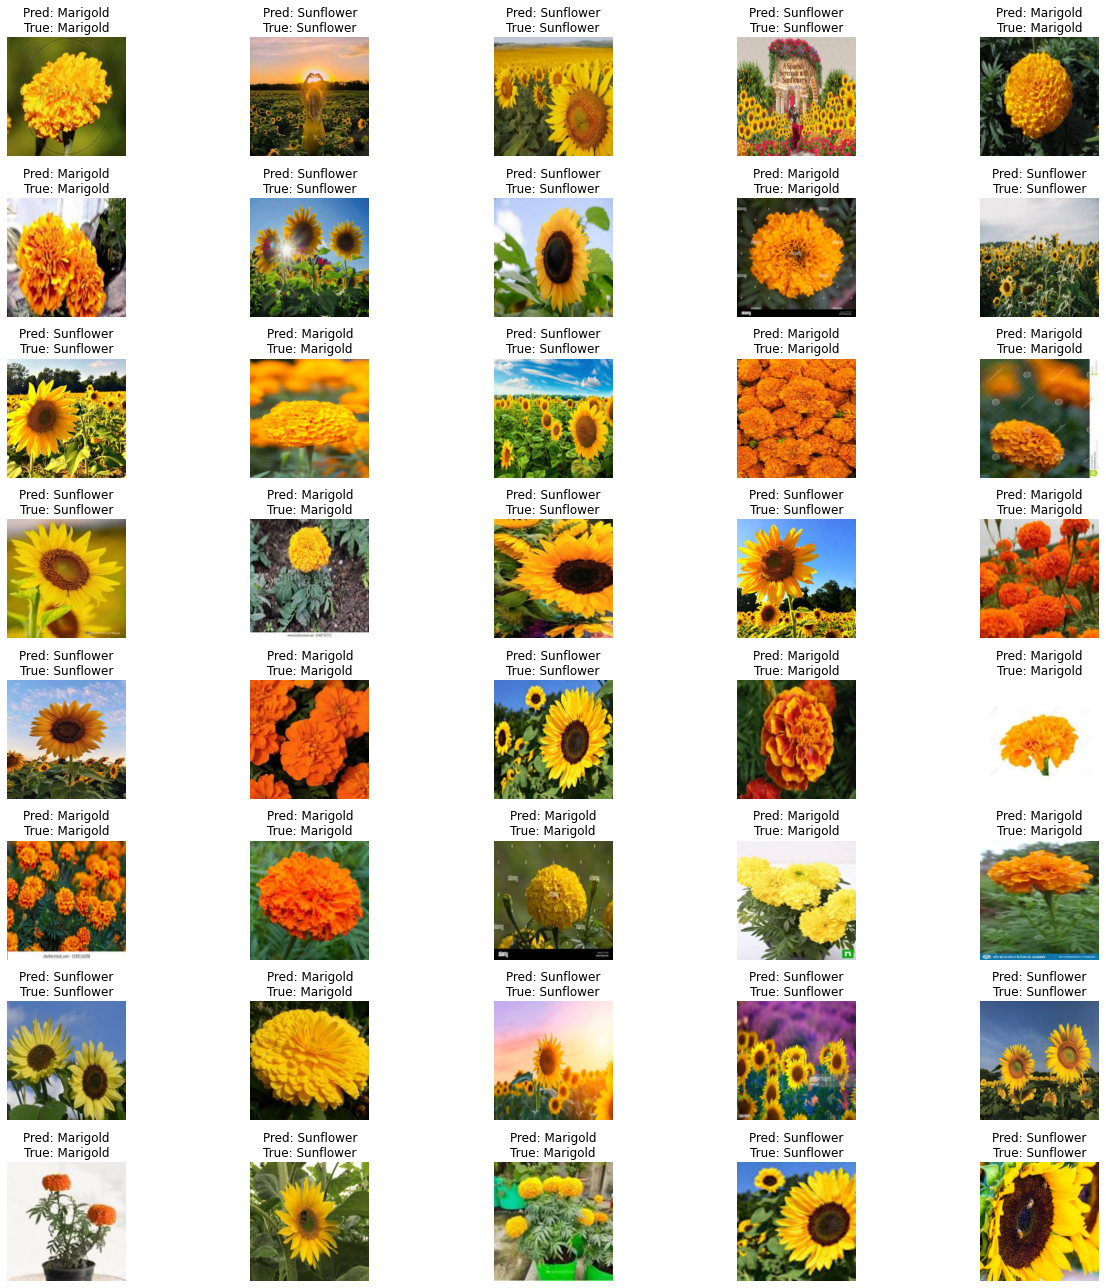

In [35]:
display_predictions(vgg_16_finetuned_all, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

In [37]:
tuple1 = ('VGG_16_finetuned_all',train_time_vgg16_finetuned_all,train_loss_vgg16_finetuned_all,train_acc_vgg16_finetuned_all,test_acc_vgg16_finetuned_all)

In [51]:
vgg_16_finetuned_MLP = models.vgg16(pretrained=True)
for param in vgg_16_finetuned_MLP.classifier.parameters():
    param.requires_grad = True

for param in vgg_16_finetuned_MLP.features.parameters():
    param.requires_grad = False

vgg_16_finetuned_MLP.classifier[6] = nn.Linear(vgg_16_finetuned_MLP.classifier[6].in_features,1)

In [52]:
train_time_vgg16_finetuned_MLP,train_loss_vgg16_finetuned_MLP,train_acc_vgg16_finetuned_MLP,test_acc_vgg16_finetuned_MLP = train_model(vgg_16_finetuned_MLP,train_loader=train_loader,test_loader=test_loader,log_dir='./logs_vgg16_finetuned_MLP',chkpt_path='vgg_16_finetuned_MLP.pth')

Epoch 1: Train Loss: 0.4697, Train Accuracy: 0.7625, Test Loss: 0.2141, Test Accuracy: 0.9000, Patience Remaining: 5


Epoch 2: Train Loss: 0.2028, Train Accuracy: 0.9187, Test Loss: 0.1573, Test Accuracy: 0.9250, Patience Remaining: 5


Epoch 3: Train Loss: 0.1136, Train Accuracy: 0.9750, Test Loss: 0.1272, Test Accuracy: 0.9250, Patience Remaining: 5


Epoch 4: Train Loss: 0.0727, Train Accuracy: 0.9938, Test Loss: 0.1114, Test Accuracy: 0.9500, Patience Remaining: 5


Epoch 5: Train Loss: 0.0625, Train Accuracy: 0.9875, Test Loss: 0.1063, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 6: Train Loss: 0.0428, Train Accuracy: 0.9938, Test Loss: 0.0992, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 7: Train Loss: 0.0362, Train Accuracy: 1.0000, Test Loss: 0.0945, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 8: Train Loss: 0.0181, Train Accuracy: 1.0000, Test Loss: 0.0874, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 9: Train Loss: 0.0210, Train Accuracy: 1.0000, Test Loss: 0.0852, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 10: Train Loss: 0.0145, Train Accuracy: 1.0000, Test Loss: 0.0804, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 11: Train Loss: 0.0108, Train Accuracy: 1.0000, Test Loss: 0.0806, Test Accuracy: 0.9750, Patience Remaining: 4


Epoch 12: Train Loss: 0.0091, Train Accuracy: 1.0000, Test Loss: 0.0787, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 13: Train Loss: 0.0104, Train Accuracy: 1.0000, Test Loss: 0.0800, Test Accuracy: 0.9750, Patience Remaining: 4


Epoch 14: Train Loss: 0.0069, Train Accuracy: 1.0000, Test Loss: 0.0787, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 15: Train Loss: 0.0076, Train Accuracy: 1.0000, Test Loss: 0.0772, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 16: Train Loss: 0.0071, Train Accuracy: 1.0000, Test Loss: 0.0791, Test Accuracy: 0.9750, Patience Remaining: 4


Epoch 17: Train Loss: 0.0053, Train Accuracy: 1.0000, Test Loss: 0.0785, Test Accuracy: 0.9750, Patience Remaining: 3


Epoch 18: Train Loss: 0.0045, Train Accuracy: 1.0000, Test Loss: 0.0771, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 19: Train Loss: 0.0045, Train Accuracy: 1.0000, Test Loss: 0.0759, Test Accuracy: 0.9750, Patience Remaining: 5


Epoch 20: Train Loss: 0.0039, Train Accuracy: 1.0000, Test Loss: 0.0749, Test Accuracy: 0.9750, Patience Remaining: 5


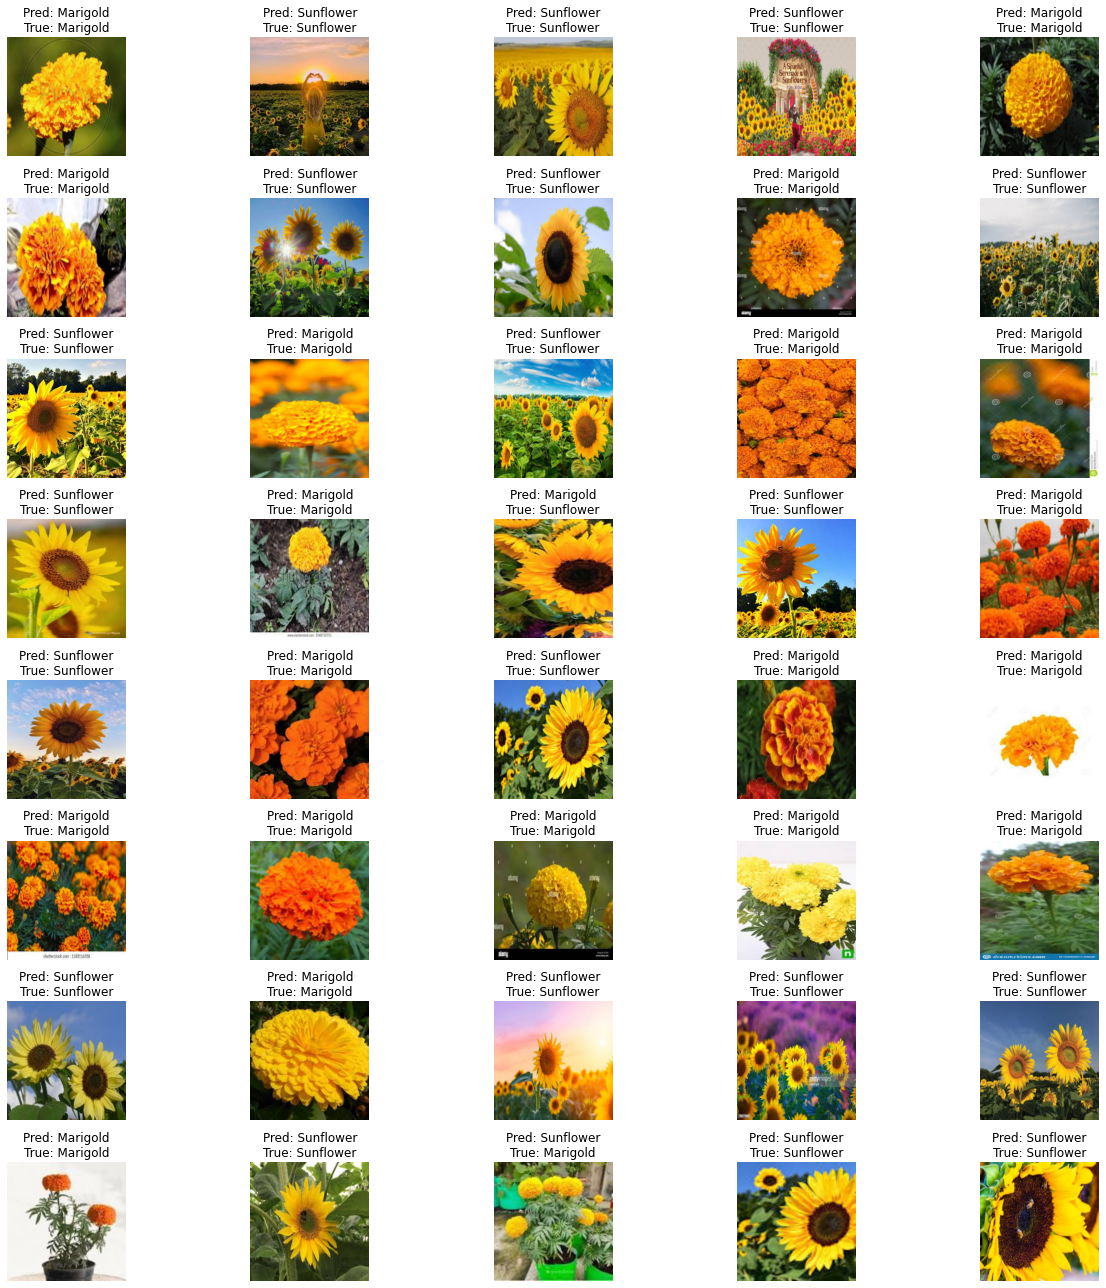

In [53]:
display_predictions(vgg_16_finetuned_MLP, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

In [54]:
tuple2 = ('VGG_16_finetuned_MLP',train_time_vgg16_finetuned_MLP,train_loss_vgg16_finetuned_MLP,train_acc_vgg16_finetuned_MLP,test_acc_vgg16_finetuned_MLP)

In [56]:
VGG1 = VGG(num_blocks=1)
train_time_vgg1,train_loss_vgg1,train_acc_vgg1,test_acc_vgg1 = train_model(VGG1,train_loader=train_loader,test_loader=test_loader,log_dir='./logs_vgg1',chkpt_path='vgg_1.pth')

Epoch 1: Train Loss: 1.6698, Train Accuracy: 0.4938, Test Loss: 0.6144, Test Accuracy: 0.5750, Patience Remaining: 5


Epoch 2: Train Loss: 0.6310, Train Accuracy: 0.5938, Test Loss: 0.5424, Test Accuracy: 0.8000, Patience Remaining: 5


Epoch 3: Train Loss: 0.5825, Train Accuracy: 0.6375, Test Loss: 0.4781, Test Accuracy: 0.9000, Patience Remaining: 5


Epoch 4: Train Loss: 0.5332, Train Accuracy: 0.6625, Test Loss: 0.4419, Test Accuracy: 0.9000, Patience Remaining: 5


Epoch 5: Train Loss: 0.4831, Train Accuracy: 0.7250, Test Loss: 0.4245, Test Accuracy: 0.8500, Patience Remaining: 5


Epoch 6: Train Loss: 0.4326, Train Accuracy: 0.7625, Test Loss: 0.4059, Test Accuracy: 0.9000, Patience Remaining: 5


Epoch 7: Train Loss: 0.3775, Train Accuracy: 0.8438, Test Loss: 0.3621, Test Accuracy: 0.8500, Patience Remaining: 5


Epoch 8: Train Loss: 0.3271, Train Accuracy: 0.8750, Test Loss: 0.3323, Test Accuracy: 0.8500, Patience Remaining: 5


Epoch 9: Train Loss: 0.2909, Train Accuracy: 0.8812, Test Loss: 0.3408, Test Accuracy: 0.8250, Patience Remaining: 4


Epoch 10: Train Loss: 0.2435, Train Accuracy: 0.9250, Test Loss: 0.3540, Test Accuracy: 0.8250, Patience Remaining: 3


Epoch 11: Train Loss: 0.1909, Train Accuracy: 0.9500, Test Loss: 0.3400, Test Accuracy: 0.8500, Patience Remaining: 2


Epoch 12: Train Loss: 0.1430, Train Accuracy: 0.9563, Test Loss: 0.3813, Test Accuracy: 0.8750, Patience Remaining: 1


Epoch 13: Train Loss: 0.1193, Train Accuracy: 0.9812, Test Loss: 0.3573, Test Accuracy: 0.8000, Patience Remaining: 0
Early stopping at epoch 13


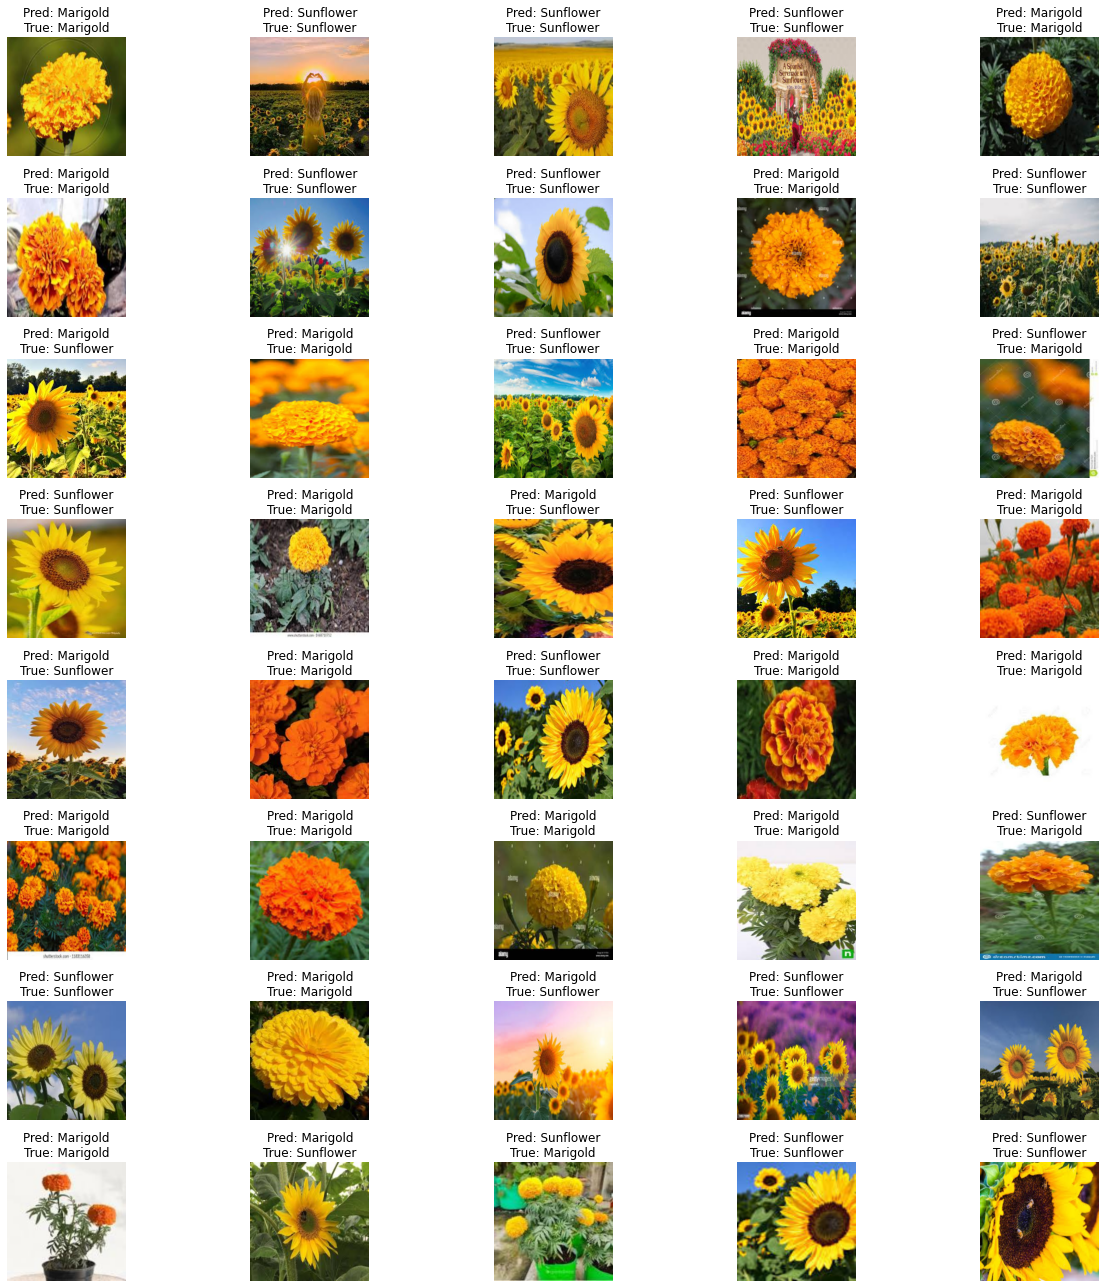

In [57]:
display_predictions(VGG1, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

In [59]:
tuple3 = ('VGG1',train_time_vgg1,train_loss_vgg1,train_acc_vgg1,test_acc_vgg1)

In [60]:
VGG3 = VGG(num_blocks=3)
train_time_vgg3,train_loss_vgg3,train_acc_vgg3,test_acc_vgg3 = train_model(VGG3,train_loader=train_loader,test_loader=test_loader,log_dir='./logs_vgg3',chkpt_path='vgg_3.pth')

Epoch 1: Train Loss: 0.6975, Train Accuracy: 0.5000, Test Loss: 0.6873, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 2: Train Loss: 0.6932, Train Accuracy: 0.5000, Test Loss: 0.6821, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 3: Train Loss: 0.6888, Train Accuracy: 0.5000, Test Loss: 0.6761, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 4: Train Loss: 0.6839, Train Accuracy: 0.5000, Test Loss: 0.6686, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 5: Train Loss: 0.6781, Train Accuracy: 0.5000, Test Loss: 0.6586, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 6: Train Loss: 0.6708, Train Accuracy: 0.5000, Test Loss: 0.6453, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 7: Train Loss: 0.6613, Train Accuracy: 0.5000, Test Loss: 0.6271, Test Accuracy: 0.5500, Patience Remaining: 5


Epoch 8: Train Loss: 0.6491, Train Accuracy: 0.5312, Test Loss: 0.6029, Test Accuracy: 0.6750, Patience Remaining: 5


Epoch 9: Train Loss: 0.6340, Train Accuracy: 0.5687, Test Loss: 0.5725, Test Accuracy: 0.8000, Patience Remaining: 5


Epoch 10: Train Loss: 0.6168, Train Accuracy: 0.6000, Test Loss: 0.5388, Test Accuracy: 0.8750, Patience Remaining: 5


Epoch 11: Train Loss: 0.5990, Train Accuracy: 0.6375, Test Loss: 0.5076, Test Accuracy: 0.8750, Patience Remaining: 5


Epoch 12: Train Loss: 0.5813, Train Accuracy: 0.6687, Test Loss: 0.4826, Test Accuracy: 0.8500, Patience Remaining: 5


Epoch 13: Train Loss: 0.5635, Train Accuracy: 0.6625, Test Loss: 0.4647, Test Accuracy: 0.8750, Patience Remaining: 5


Epoch 14: Train Loss: 0.5453, Train Accuracy: 0.6813, Test Loss: 0.4528, Test Accuracy: 0.8500, Patience Remaining: 5


Epoch 15: Train Loss: 0.5270, Train Accuracy: 0.6875, Test Loss: 0.4464, Test Accuracy: 0.8500, Patience Remaining: 5


Epoch 16: Train Loss: 0.5087, Train Accuracy: 0.7125, Test Loss: 0.4446, Test Accuracy: 0.8000, Patience Remaining: 5


Epoch 17: Train Loss: 0.4896, Train Accuracy: 0.7188, Test Loss: 0.4447, Test Accuracy: 0.7750, Patience Remaining: 4


Epoch 18: Train Loss: 0.4700, Train Accuracy: 0.7188, Test Loss: 0.4468, Test Accuracy: 0.8000, Patience Remaining: 3


Epoch 19: Train Loss: 0.4496, Train Accuracy: 0.7250, Test Loss: 0.4503, Test Accuracy: 0.8000, Patience Remaining: 2


Epoch 20: Train Loss: 0.4287, Train Accuracy: 0.7500, Test Loss: 0.4538, Test Accuracy: 0.8000, Patience Remaining: 1


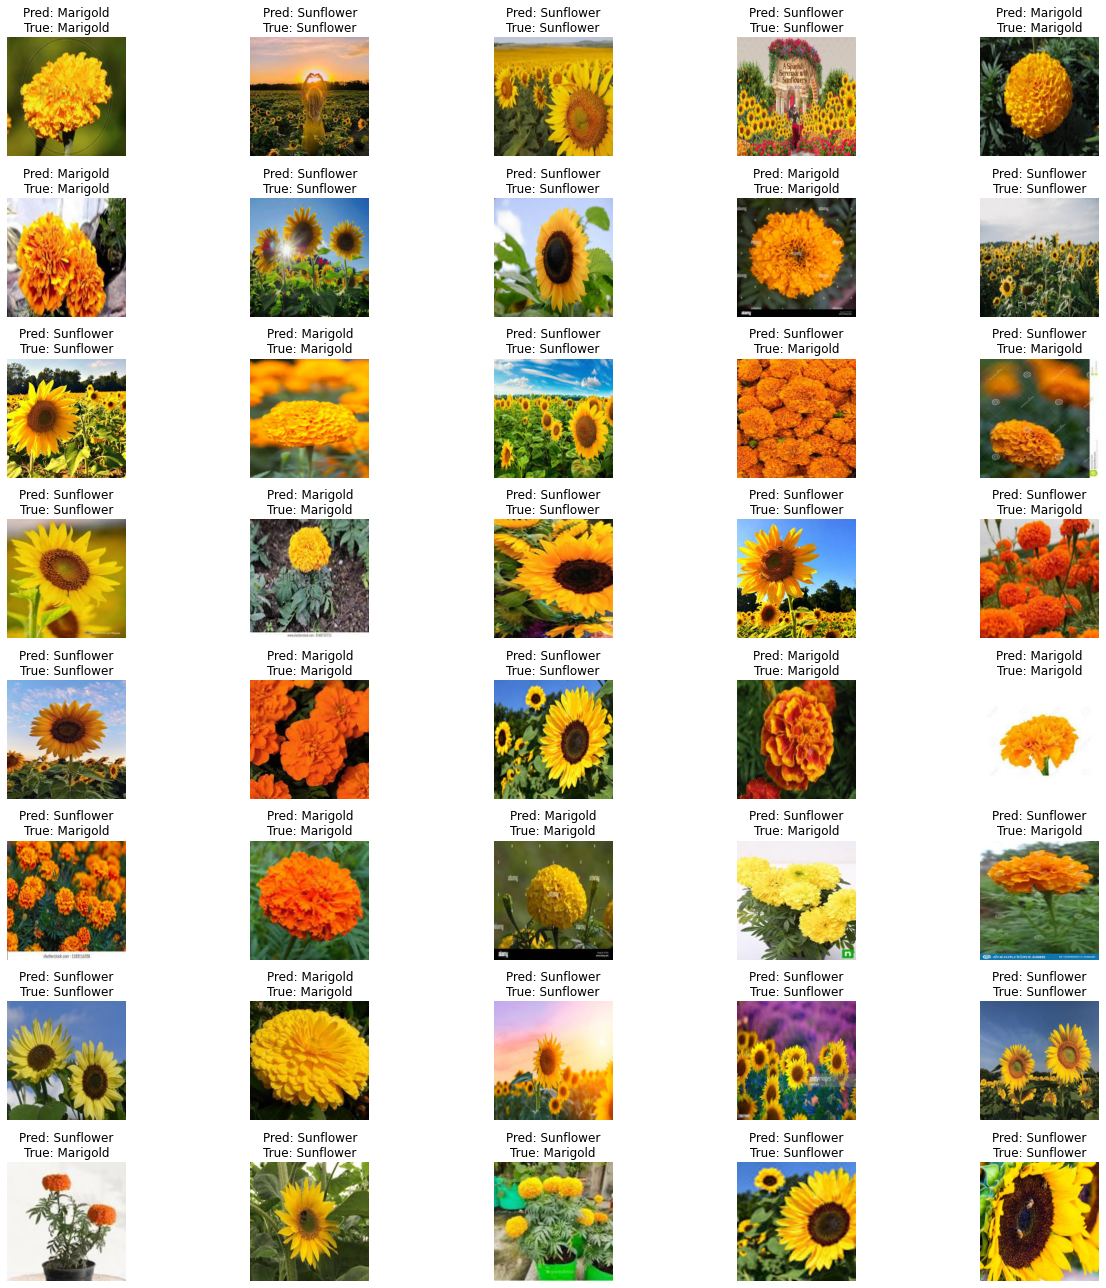

In [61]:
display_predictions(VGG3, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

In [62]:
tuple4 = ('VGG3',train_time_vgg3,train_loss_vgg3,train_acc_vgg3,test_acc_vgg3)

In [63]:
marigold_train = load_img_paths('augmented_dataset/train/marigold')
sunflower_train = load_img_paths('augmented_dataset/train/sunflower')

marigold_train = list(zip(marigold_train,[0]*len(marigold_train)))
sunflower_train = list(zip(sunflower_train,[1]*len(sunflower_train)))

marigold_test = load_img_paths('augmented_dataset/test/marigold')
sunflower_test = load_img_paths('augmented_dataset/test/sunflower')

marigold_test = list(zip(marigold_test,[0]*len(marigold_test)))
sunflower_test = list(zip(sunflower_test,[1]*len(sunflower_test)))

dataset_train = marigold_train+sunflower_train
dataset_test = marigold_test+sunflower_test

In [64]:
train_dataset = flowerDataset(dataset_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = flowerDataset(dataset_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [65]:
VGG3_augmented = VGG(num_blocks=3)
train_time_vgg3_augment,train_loss_vgg3_augment,train_acc_vgg3_augment,test_acc_vgg3_augment = train_model(VGG3_augmented,train_loader=train_loader,test_loader=test_loader,log_dir='./logs_vgg3_augment',chkpt_path='vgg_3_augment.pth')

Epoch 1: Train Loss: 0.6888, Train Accuracy: 0.5000, Test Loss: 0.6937, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 2: Train Loss: 0.6785, Train Accuracy: 0.5000, Test Loss: 0.6730, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 3: Train Loss: 0.6511, Train Accuracy: 0.5156, Test Loss: 0.6511, Test Accuracy: 0.5000, Patience Remaining: 5


Epoch 4: Train Loss: 0.6005, Train Accuracy: 0.6302, Test Loss: 0.6438, Test Accuracy: 0.7000, Patience Remaining: 5


Epoch 5: Train Loss: 0.5541, Train Accuracy: 0.7104, Test Loss: 0.5689, Test Accuracy: 0.7000, Patience Remaining: 5


Epoch 6: Train Loss: 0.4969, Train Accuracy: 0.7344, Test Loss: 0.6307, Test Accuracy: 0.7000, Patience Remaining: 4


Epoch 7: Train Loss: 0.4864, Train Accuracy: 0.7667, Test Loss: 0.6865, Test Accuracy: 0.7250, Patience Remaining: 3


Epoch 8: Train Loss: 0.4463, Train Accuracy: 0.7802, Test Loss: 0.5710, Test Accuracy: 0.7250, Patience Remaining: 2


Epoch 9: Train Loss: 0.4024, Train Accuracy: 0.8146, Test Loss: 0.6006, Test Accuracy: 0.7250, Patience Remaining: 1


Epoch 10: Train Loss: 0.4031, Train Accuracy: 0.8042, Test Loss: 0.6699, Test Accuracy: 0.7500, Patience Remaining: 0
Early stopping at epoch 10


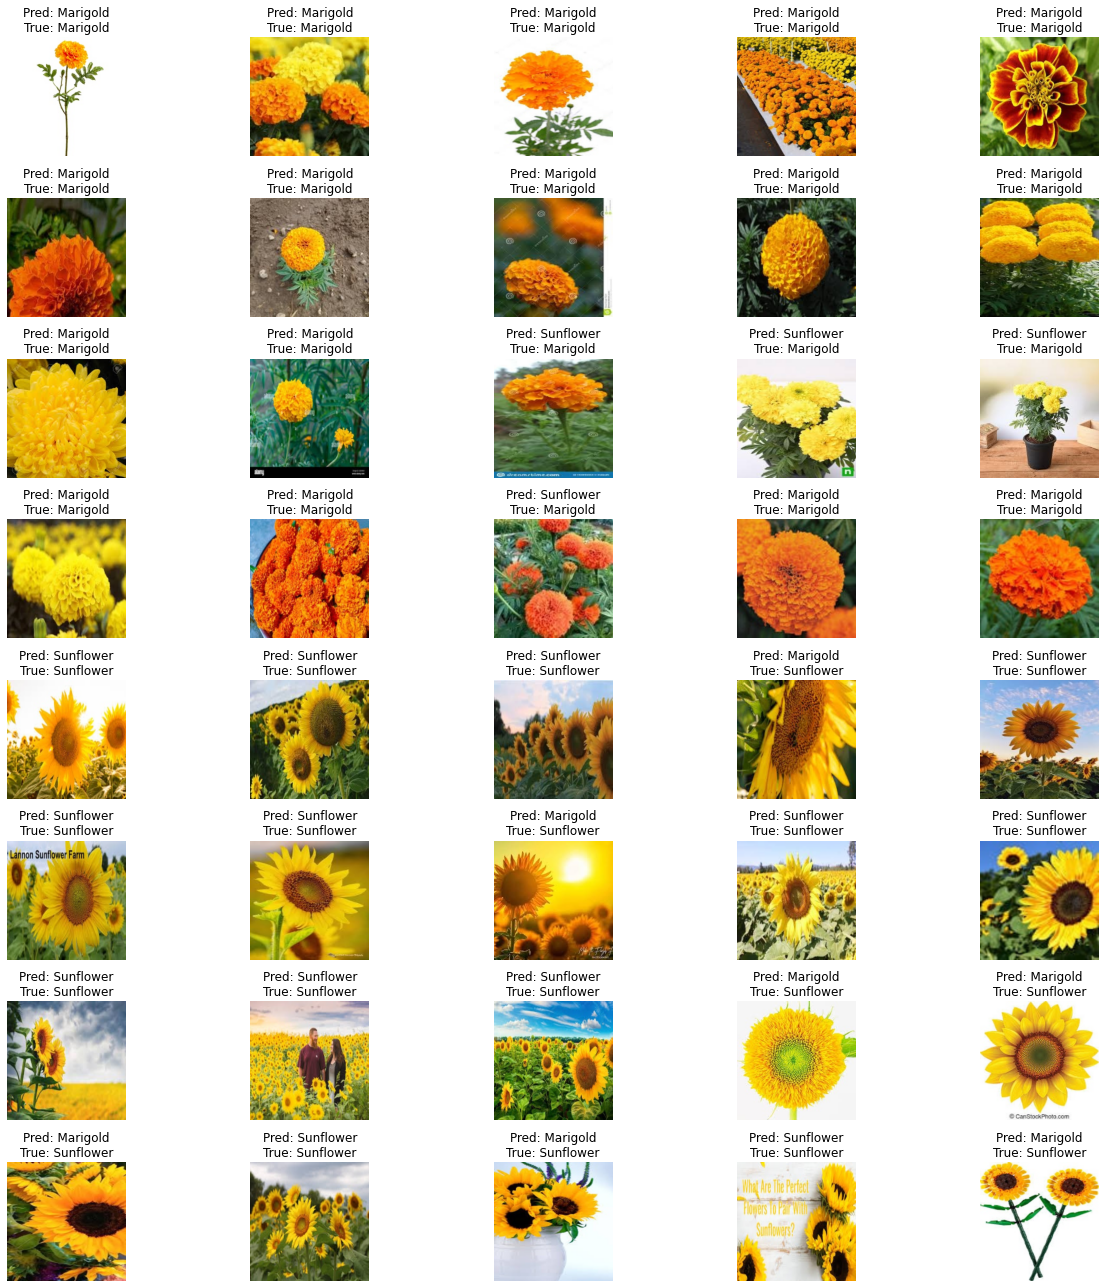

In [68]:
display_predictions(VGG3_augmented, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

In [69]:
tuple5 = ('VGG_Block3_Augmented',train_time_vgg3_augment,train_loss_vgg3_augment,train_acc_vgg3_augment,test_acc_vgg3_augment)

In [70]:
pd.DataFrame([tuple1,tuple2,tuple3,tuple4,tuple5],columns=['Model','Train_time','Train_loss','train_acc','test_acc'])

Model   Train_time  Train_loss  train_acc  test_acc
0  VGG_16_finetuned_all  1060.455939    0.085906   0.962500  0.990000
1  VGG_16_finetuned_MLP   872.047704    0.056199   0.981563  0.965000
2                  VGG1   125.966706    0.463410   0.791346  0.830769
3                  VGG3   169.707319    0.591809   0.608125  0.708750
4  VGG_Block3_Augmented   448.170249    0.540814   0.675625  0.652500